## Multi Label

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set paths
import pandas as pd
import os

csv_path = '/content/drive/MyDrive/NIH_Xray_Project/Data_Entry_2017.csv'
image_dir = '/content/drive/MyDrive/NIH_Xray_Project/images'

# Load metadata
df = pd.read_csv(csv_path)

# Filter to only include available images
available_images = set(os.listdir(image_dir))
df = df[df['Image Index'].isin(available_images)].reset_index(drop=True)

# Focus on 3 target diseases
target_labels = ['Atelectasis', 'Effusion', 'Infiltration']

# Convert pipe-separated string labels to list
df['Finding Labels'] = df['Finding Labels'].apply(lambda x: x.split('|'))

# One-hot encode the 3 diseases
for disease in target_labels:
    df[disease] = df['Finding Labels'].apply(lambda labels: int(disease in labels))

# Filter rows where at least one of the 3 diseases is present
df_filtered = df[df[target_labels].sum(axis=1) > 0].reset_index(drop=True)

print(f"Filtered image count: {len(df_filtered)}")
df_filtered = df_filtered[['Image Index'] + target_labels]
df_filtered.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Filtered image count: 1460


,Image Index,Atelectasis,Effusion,Infiltration
0,00000001_002.png,0,1,0
1,00000003_003.png,0,0,1
2,00000005_006.png,0,0,1
3,00000005_007.png,0,1,1
4,00000010_000.png,0,0,1


In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

# Transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Custom dataset
class ChestXrayDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.data = dataframe
        self.image_dir = image_dir
        self.transform = transform
        self.labels = self.data[['Atelectasis', 'Effusion', 'Infiltration']].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]['Image Index']
        img_path = os.path.join(self.image_dir, img_name)

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return image, label

In [ ]:
from torch.utils.data import DataLoader, random_split

# Create full dataset
dataset = ChestXrayDataset(df_filtered, image_dir=image_dir, transform=transform)

# Compute sizes
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

Train: 1021 | Val: 219 | Test: 220


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ResNet-18
model = models.resnet18(pretrained=True)

# Modify final layer for 3-label output
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)  # 3 classes: Atelectasis, Effusion, Infiltration

model = model.to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 87.0MB/s]


In [ ]:
import time

# Training loop (light version)
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    start_time = time.time()

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    duration = time.time() - start_time
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Time: {duration:.1f}s")

Epoch 1/5 - Loss: 0.6370 - Time: 233.1s
Epoch 2/5 - Loss: 0.3732 - Time: 22.1s
Epoch 3/5 - Loss: 0.1673 - Time: 20.7s
Epoch 4/5 - Loss: 0.0663 - Time: 22.2s
Epoch 5/5 - Loss: 0.0358 - Time: 21.5s


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# Evaluation mode
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu().numpy()
        all_preds.append(probs)
        all_targets.append(labels.numpy())

# Stack all batches
all_preds = np.vstack(all_preds)
all_targets = np.vstack(all_targets)

# Apply threshold of 0.3
threshold = 0.3
binary_preds = (all_preds >= threshold).astype(int)

# Per-class metrics
print(" Classification Report (Threshold = 0.3):")
print(classification_report(all_targets, binary_preds, target_names=target_labels))

# ROC-AUC
print("\n ROC-AUC Scores:")
for i, label in enumerate(target_labels):
    score = roc_auc_score(all_targets[:, i], all_preds[:, i])
    print(f"{label}: {score:.2f}")

📊 Classification Report (Threshold = 0.3):
              precision    recall  f1-score   support

 Atelectasis       0.54      0.69      0.60        64
    Effusion       0.61      0.80      0.69        88
Infiltration       0.58      0.80      0.67       118

   micro avg       0.58      0.77      0.66       270
   macro avg       0.57      0.76      0.65       270
weighted avg       0.58      0.77      0.66       270
 samples avg       0.62      0.79      0.66       270


📈 ROC-AUC Scores:
Atelectasis: 0.78
Effusion: 0.79
Infiltration: 0.67


In [ ]:
import torch
import numpy as np

model.eval()
y_probs = []
y_test = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs).cpu().numpy()
        y_probs.append(probs)
        y_test.append(labels.numpy())

# Stack into full arrays
y_probs = np.vstack(y_probs)
y_test = np.vstack(y_test)

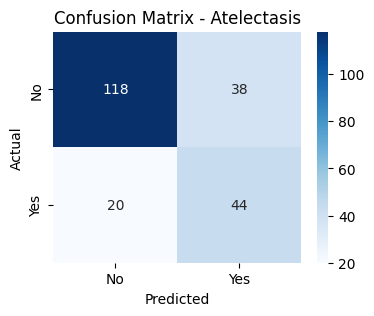

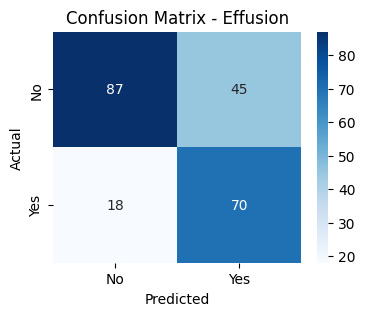

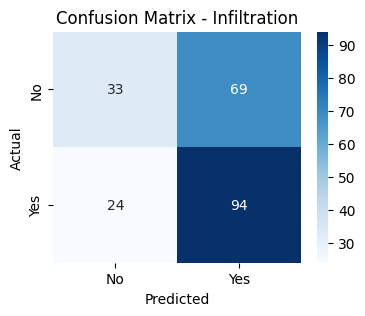

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(y_true, y_pred, class_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {class_name}")
    plt.show()

# Assuming y_true and y_pred are your binarized test labels and predictions
for i, disease in enumerate(['Atelectasis', 'Effusion', 'Infiltration']):
    y_true_d = y_test[:, i]
    y_pred_d = (y_probs[:, i] > 0.3).astype(int)
    plot_confusion_matrix(y_true_d, y_pred_d, disease)

In [ ]:
# Look at test set labels to find examples for each disease
for i in range(len(test_dataset)):
    _, label = test_dataset[i]
    if label[0] == 1:  # Atelectasis
        print("Atelectasis:", df_filtered.iloc[test_dataset.indices[i]]['Image Index'])
        break

for i in range(len(test_dataset)):
    _, label = test_dataset[i]
    if label[1] == 1:  # Effusion
        print("Effusion:", df_filtered.iloc[test_dataset.indices[i]]['Image Index'])
        break

for i in range(len(test_dataset)):
    _, label = test_dataset[i]
    if label[2] == 1:  # Infiltration
        print("Infiltration:", df_filtered.iloc[test_dataset.indices[i]]['Image Index'])
        break

Atelectasis: 00001140_001.png
Effusion: 00000250_008.png
Infiltration: 00000116_007.png


In [ ]:
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Grad-CAM class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def __call__(self, input_tensor, class_idx):
        self.model.zero_grad()
        output = self.model(input_tensor)
        loss = output[0, class_idx]
        loss.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=(224, 224), mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


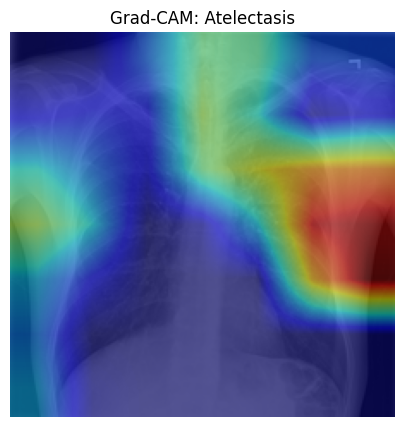

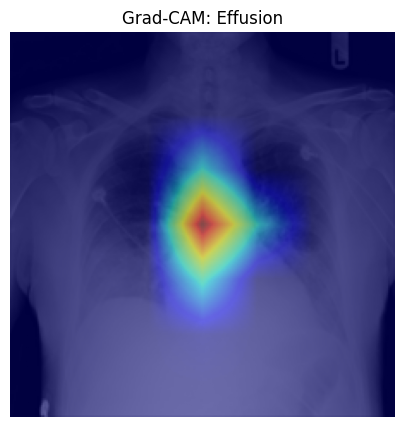

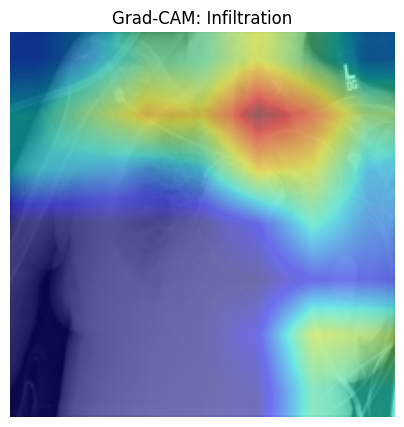

In [ ]:
# Define transform (same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def show_gradcam(image_path, class_idx, class_name):
    # Load image
    img_path = os.path.join(image_dir, image_path)
    pil_img = Image.open(img_path).convert('RGB')
    input_tensor = transform(pil_img).unsqueeze(0).to(device)

    # Run Grad-CAM
    target_layer = model.layer4[-1]  # Last convolutional block
    cam_generator = GradCAM(model, target_layer)
    cam = cam_generator(input_tensor, class_idx)

    # Prepare original image for overlay
    img_np = np.array(pil_img.resize((224, 224))) / 255.0
    if img_np.ndim == 2:
        img_np = np.repeat(img_np[..., np.newaxis], 3, axis=2)

    # Overlay heatmap
    plt.figure(figsize=(5, 5))
    plt.imshow(img_np)
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title(f"Grad-CAM: {class_name}")
    plt.axis('off')
    plt.show()

# 🔍 Generate Grad-CAMs
show_gradcam("00001140_001.png", 0, "Atelectasis")
show_gradcam("00000250_008.png", 1, "Effusion")
show_gradcam("00000116_007.png", 2, "Infiltration")

## Multi-Class Classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import torch

# Paths
csv_path = '/content/drive/MyDrive/NIH_Xray_Project/Data_Entry_2017.csv'
image_dir = '/content/drive/MyDrive/NIH_Xray_Project/images'

# Load metadata
df = pd.read_csv(csv_path)

# Multi-class target classes
target_classes = ['Atelectasis', 'Effusion', 'Infiltration']

# Keep rows with exactly one of the target classes
def single_target(row):
    labels = row.split('|')
    matches = [d for d in target_classes if d in labels]
    return matches[0] if len(matches) == 1 else None

df['Target'] = df['Finding Labels'].apply(single_target)
df = df[df['Target'].notna()].reset_index(drop=True)

# Encode classes as integers
class_to_id = {label: idx for idx, label in enumerate(target_classes)}
df['ClassID'] = df['Target'].map(class_to_id)

# Compute class weights for imbalanced training
class_counts = df['ClassID'].value_counts().sort_index()
total_samples = len(df)
weights = [total_samples / (3 * class_counts[i]) for i in range(3)]
weights_tensor = torch.tensor(weights, dtype=torch.float32)

print(f" Filtered dataset contains {len(df)} single-label images")
print(" Class distribution:", dict(class_counts))
print(" Class weights (for CrossEntropyLoss):", weights_tensor)

df[['Image Index', 'Target', 'ClassID']].head()

 Filtered dataset contains 27409 single-label images
 Class distribution: {0: np.int64(6259), 1: np.int64(7281), 2: np.int64(13869)}
 Class weights (for CrossEntropyLoss): tensor([1.4597, 1.2548, 0.6588])


,Image Index,Target,ClassID
0,00000001_002.png,Effusion,1
1,00000003_003.png,Infiltration,2
2,00000005_006.png,Infiltration,2
3,00000010_000.png,Infiltration,2
4,00000011_000.png,Effusion,1


In [ ]:
df = df[df['Image Index'].isin(images_on_disk)].reset_index(drop=True)

In [ ]:
import os
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

# Image transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet stats
                         std=[0.229, 0.224, 0.225])
])

# Dataset class for multi-class classification
class ChestXrayMulticlass(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(self.image_dir, row['Image Index'])
        image = Image.open(img_path).convert("RGB")
        label = row['ClassID']

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
from torch.utils.data import DataLoader, random_split

# Dataset instance
full_dataset = ChestXrayMulticlass(df, image_dir=image_dir, transform=transform)

# Split sizes
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Random split
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

Train: 3756 | Val: 805 | Test: 806


In [ ]:
import torch.nn as nn
from torchvision import models

# Load pre-trained ResNet18
resnet = models.resnet18(pretrained=True)

# Replace the final FC layer for 3-class classification
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 3)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet.to(device)

# Define weighted CrossEntropyLoss
class_weights = torch.tensor([1.4597, 1.2548, 0.6588], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=3e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import time
from tqdm import tqdm
import torch

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        loop = tqdm(train_loader, desc=f"[Epoch {epoch+1}/{num_epochs}]")
        for batch_idx, (images, labels) in enumerate(loop):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)

            if torch.isnan(loss):
                print(f"🚨 NaN loss at batch {batch_idx}")
                continue

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

            loop.set_postfix(batch=batch_idx, loss=loss.item())

        train_acc = correct_train / total_train if total_train > 0 else 0

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_acc = correct_val / total_val if total_val > 0 else 0
        elapsed = time.time() - start_time
        print(f"\n✅ Epoch {epoch+1} complete in {elapsed:.2f}s")
        print(f"📉 Loss = {running_loss/len(train_loader):.4f} | 🏋️‍♂️ Train Acc = {train_acc:.4f} | 🔍 Val Acc = {val_acc:.4f}")

In [ ]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=10
)

[Epoch 1/10]: 100%|██████████| 118/118 [25:49<00:00, 13.13s/it, batch=117, loss=1.24]



✅ Epoch 1 complete in 1910.76s
📉 Loss = 1.0296 | 🏋️‍♂️ Train Acc = 0.5141 | 🔍 Val Acc = 0.5938


[Epoch 2/10]: 100%|██████████| 118/118 [01:24<00:00,  1.39it/s, batch=117, loss=0.734]



✅ Epoch 2 complete in 101.46s
📉 Loss = 0.8256 | 🏋️‍♂️ Train Acc = 0.6294 | 🔍 Val Acc = 0.4795


[Epoch 3/10]: 100%|██████████| 118/118 [01:21<00:00,  1.45it/s, batch=117, loss=0.867]



✅ Epoch 3 complete in 97.74s
📉 Loss = 0.6846 | 🏋️‍♂️ Train Acc = 0.7106 | 🔍 Val Acc = 0.5963


[Epoch 4/10]: 100%|██████████| 118/118 [01:22<00:00,  1.43it/s, batch=117, loss=0.27]



✅ Epoch 4 complete in 99.70s
📉 Loss = 0.5253 | 🏋️‍♂️ Train Acc = 0.7798 | 🔍 Val Acc = 0.6298


[Epoch 5/10]: 100%|██████████| 118/118 [01:19<00:00,  1.48it/s, batch=117, loss=0.0435]



✅ Epoch 5 complete in 98.02s
📉 Loss = 0.3496 | 🏋️‍♂️ Train Acc = 0.8647 | 🔍 Val Acc = 0.5317


[Epoch 6/10]: 100%|██████████| 118/118 [01:21<00:00,  1.46it/s, batch=117, loss=0.44]



✅ Epoch 6 complete in 98.30s
📉 Loss = 0.2201 | 🏋️‍♂️ Train Acc = 0.9164 | 🔍 Val Acc = 0.5652


[Epoch 7/10]: 100%|██████████| 118/118 [01:19<00:00,  1.49it/s, batch=117, loss=0.454]



✅ Epoch 7 complete in 96.55s
📉 Loss = 0.2036 | 🏋️‍♂️ Train Acc = 0.9236 | 🔍 Val Acc = 0.5180


[Epoch 8/10]: 100%|██████████| 118/118 [01:21<00:00,  1.44it/s, batch=117, loss=0.0434]



✅ Epoch 8 complete in 98.19s
📉 Loss = 0.1222 | 🏋️‍♂️ Train Acc = 0.9555 | 🔍 Val Acc = 0.5230


[Epoch 9/10]: 100%|██████████| 118/118 [01:20<00:00,  1.46it/s, batch=117, loss=0.518]



✅ Epoch 9 complete in 97.34s
📉 Loss = 0.0893 | 🏋️‍♂️ Train Acc = 0.9710 | 🔍 Val Acc = 0.5677


[Epoch 10/10]: 100%|██████████| 118/118 [01:21<00:00,  1.45it/s, batch=117, loss=0.0149]



✅ Epoch 10 complete in 98.59s
📉 Loss = 0.1103 | 🏋️‍♂️ Train Acc = 0.9609 | 🔍 Val Acc = 0.5901


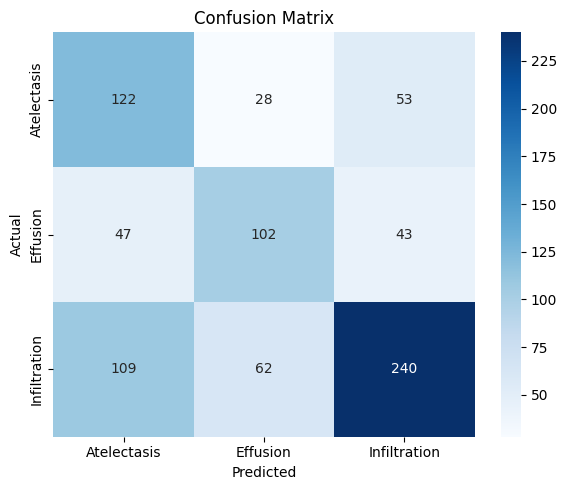

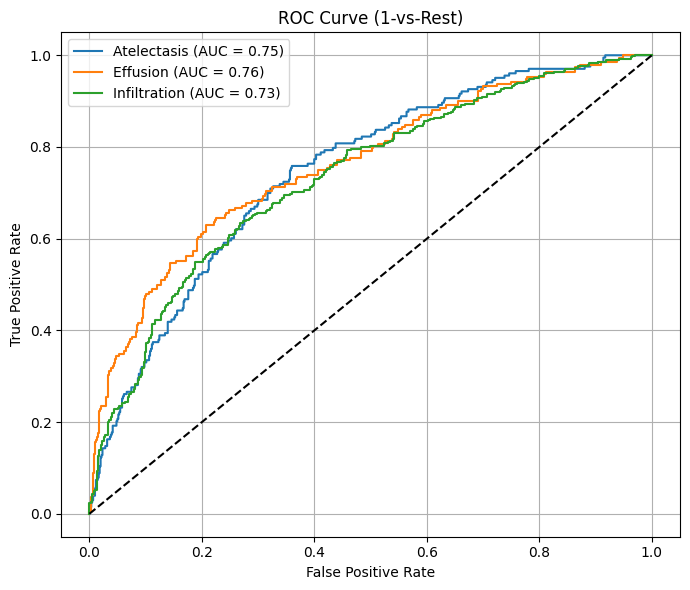

Precision: 0.6013
Recall: 0.5757
F1 Score: 0.5820
F2 Score: 0.5806
ROC AUC by Class: {0: np.float64(0.7455701786633336), 1: np.float64(0.7608238327904453), 2: np.float64(0.7340971388093258)}


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

# Collect predictions
model.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert to arrays
y_true = np.array(all_labels)
y_pred = np.array(all_preds)
y_prob = np.array(all_probs)
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])

# Classification report
target_names = ['Atelectasis', 'Effusion', 'Infiltration']
report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
conf_matrix = confusion_matrix(y_true, y_pred)

# ROC Curves
fpr, tpr, roc_auc = {}, {}, {}
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC Curves
plt.figure(figsize=(7, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'{target_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve (1-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Scores
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']
f2 = (5 * precision * recall) / (4 * precision + recall) if (4 * precision + recall) else 0

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"F2 Score: {f2:.4f}")
print("ROC AUC by Class:", roc_auc)

In [ ]:
from sklearn.metrics import classification_report

# y_true: true class IDs from the test set
# y_pred: predicted class IDs from your model

print("📊 Classification Report (Per-Class Precision/Recall/F1):")
print(classification_report(y_true, y_pred, target_names=target_classes))

📊 Classification Report (Per-Class Precision/Recall/F1):
              precision    recall  f1-score   support

 Atelectasis       0.44      0.60      0.51       203
    Effusion       0.53      0.53      0.53       192
Infiltration       0.71      0.58      0.64       411

    accuracy                           0.58       806
   macro avg       0.56      0.57      0.56       806
weighted avg       0.60      0.58      0.58       806



grad cam


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image

# Grad-CAM hook storage
activations = {}
gradients = {}

# Hook functions
def forward_hook(module, input, output):
    activations['value'] = output.detach()

def backward_hook(module, grad_in, grad_out):
    gradients['value'] = grad_out[0].detach()

# Register hooks on final conv layer of ResNet18
target_layer = model.layer4[1].conv2
target_layer.register_forward_hook(forward_hook)
target_layer.register_backward_hook(backward_hook)

In [ ]:
def generate_gradcam(image_tensor, class_idx):
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(device)

    # Forward pass
    output = model(image_tensor)
    class_score = output[0, class_idx]

    # Backward pass
    model.zero_grad()
    class_score.backward()

    # Get activations and gradients
    act = activations['value']           # (B, C, H, W)
    grad = gradients['value']            # (B, C, H, W)

    weights = grad.mean(dim=(2, 3), keepdim=True)  # global average pooling
    cam = (weights * act).sum(dim=1, keepdim=True)
    cam = F.relu(cam)

    # Normalize and resize
    cam = cam.squeeze().cpu().numpy()
    cam = (cam - cam.min()) / (cam.max() + 1e-8)
    cam = np.uint8(255 * cam)
    cam = Image.fromarray(cam).resize((224, 224), resample=Image.BILINEAR)
    cam = np.array(cam)

    return cam

In [ ]:
def show_gradcam_on_image(img_tensor, cam, title='Grad-CAM'):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = (img * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title(title)
    plt.show()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


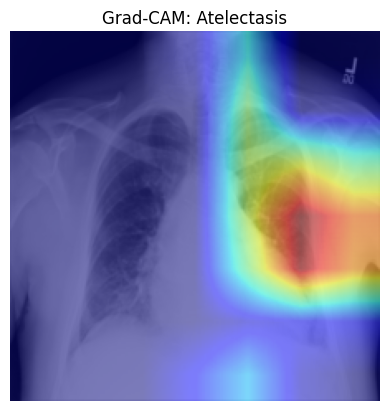

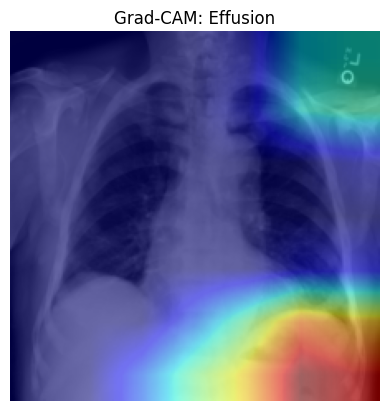

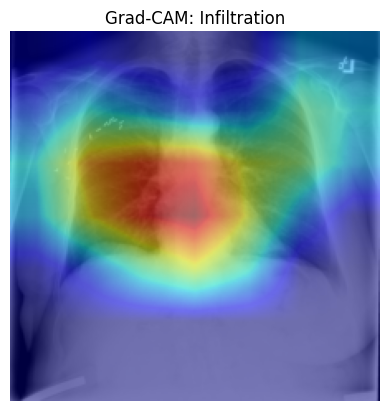

In [ ]:
# Replace these with actual paths to test images from your dataset
sample_paths = {
    "Atelectasis": "00000001_002.png",
    "Effusion":    "00000011_000.png",
    "Infiltration": "00000003_003.png"
}

for label_name, file_name in sample_paths.items():
    path = os.path.join(image_dir, file_name)
    img = Image.open(path).convert("RGB")
    input_tensor = transform(img)

    class_id = class_to_id[label_name]
    cam = generate_gradcam(input_tensor, class_id)
    show_gradcam_on_image(input_tensor, cam, title=f"Grad-CAM: {label_name}")

Files check

In [ ]:
import os

missing = []
existing = []
for idx, row in df.iterrows():
    img_path = os.path.join(image_dir, row['Image Index'])
    if not os.path.exists(img_path):
        missing.append(img_path)
    else:
        existing.append(img_path)

print(f"✅ Found {len(existing)} images")
print(f"❌ Missing {len(missing)} images")
if missing:
    print("Example missing files:", missing[:5])

✅ Found 5367 images
❌ Missing 22042 images
Example missing files: ['/content/drive/MyDrive/NIH_Xray_Project/images/00006585_007.png', '/content/drive/MyDrive/NIH_Xray_Project/images/00006585_009.png', '/content/drive/MyDrive/NIH_Xray_Project/images/00006585_010.png', '/content/drive/MyDrive/NIH_Xray_Project/images/00006585_011.png', '/content/drive/MyDrive/NIH_Xray_Project/images/00006585_012.png']


In [ ]:
import os

image_dir = '/content/drive/MyDrive/NIH_Xray_Project/images'

# Recursively list all PNG files
all_files = []
for root, dirs, files in os.walk(image_dir):
    for file in files:
        if file.lower().endswith('.png'):
            all_files.append(os.path.join(root, file))

print(f"✅ Total PNG files found in 'images': {len(all_files)}")

✅ Total PNG files found in 'images': 25089


In [ ]:
import pandas as pd
import os

# Path to your images folder and CSV
image_dir = '/content/drive/MyDrive/NIH_Xray_Project/images'
csv_path = '/content/drive/MyDrive/NIH_Xray_Project/Data_Entry_2017.csv'

# Load CSV and filter to relevant images
df = pd.read_csv(csv_path)
target_classes = ['Atelectasis', 'Effusion', 'Infiltration']
df['Target'] = df['Finding Labels'].apply(lambda x: next((c for c in target_classes if c in x.split('|')), None))
df = df[df['Target'].notna()].reset_index(drop=True)

# Image list from disk and from CSV
images_on_disk = set(os.listdir(image_dir))
images_in_df = set(df['Image Index'])

missing_images = images_in_df - images_on_disk
print(f"✅ Total in CSV: {len(images_in_df)}")
print(f"✅ Found in folder: {len(images_on_disk)}")
print(f"✅ Matched: {len(images_in_df & images_on_disk)}")
print(f"❌ Missing: {len(missing_images)}")
print(f"🔎 Sample missing: {list(missing_images)[:5]}")

✅ Total in CSV: 35470
✅ Found in folder: 25089
✅ Matched: 6760
❌ Missing: 28710
🔎 Sample missing: ['00028544_004.png', '00008339_010.png', '00029617_008.png', '00017651_010.png', '00017950_001.png']


In [ ]:
sorted(list(images_on_disk))[:10]  # View the first 10 image filenames in the folder

['00000001_000.png',
 '00000001_001.png',
 '00000001_002.png',
 '00000002_000.png',
 '00000003_000.png',
 '00000003_001.png',
 '00000003_002.png',
 '00000003_003.png',
 '00000003_004.png',
 '00000003_005.png']

In [ ]:
sorted(list(images_in_df))[:10]  # View first 10 from CSV

['00000001_002.png',
 '00000003_003.png',
 '00000005_006.png',
 '00000005_007.png',
 '00000010_000.png',
 '00000011_000.png',
 '00000011_005.png',
 '00000011_006.png',
 '00000011_007.png',
 '00000012_000.png']